In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import platform


# unused import
#from ipywidgets import interact

sys = platform.system()
old_dir = os.getcwd()

# return a dataframe with all data since 2009
def getConcatenatedDF(who):
    os.chdir(old_dir)
    if (sys=='Darwin' or sys=='Linux'):
        os.chdir('./data/'+who)
    elif (sys =='Windows'):
        if (who == 'Applications'):
            os.chdir(r'C:\Users\Luis\desktop\INAPI\data\Applications')
        else:
            os.chdir(r'C:\Users\Luis\desktop\INAPI\data\Registers')
    
    r = os.listdir()
    df= []

    for i in r:
        df.append(pd.DataFrame(pd.read_excel(i, sheet_name=0)))

    df = pd.concat(df)

    df["Year"] = df["ApplicationNumber"].astype(str).str[0:4]
    
    #always return to the main folder to prevent errors
    os.chdir(old_dir)
    return df

def grafico(dataframe):
    sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
    ax = sns.barplot(x="ApplicationNumber", y="Applicants", data=dataframe)
    ax.set_ylabel("Solicitantes")
    ax.set_xlabel("Número de Aplicaciones")
    
def compareGraf(df1,df2):
    #use applicants as df1, and registers as df2
    sns.set_theme(style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 15))
    sns.set_color_codes("pastel")
    sns.barplot(x="ApplicationNumber", y="Applicants", data=df1,
            label="N° de Aplicaciones", color="b")
    sns.set_color_codes("muted")
    sns.barplot(x="ApplicationNumber", y="Applicants", data=df2,
            label="N° de registros", color="b")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="",
           xlabel="N°")
    sns.despine(left=True, bottom=True)

In [48]:
df = getConcatenatedDF('Applications')
df_macrozone = df[df["ApplicantRegion"].isin(["Maule", "Bío Bío", "Ñuble", "Libertador B. O'Higgins"])].copy()


df_registers = getConcatenatedDF('Registers')
df_macrozone2 =  df_registers[df_registers["ApplicantRegion"].isin(["Maule", "Bío Bío", "Ñuble", "Libertador B. O'Higgins"])].copy()

d = df[df["Applicants"].str.contains("UNIVERSIDAD DE CONCEPCION", regex=True, na=False)]

d[d["ApplicantRegion"] == "No disponible"]

,ApplicationNumber,RegistrationNumber,Applicants,Representatives,Inventors,FilingDate,PublicationDate,RegistrationDate,ExpirationDate,Title,...,SubtypeName,Status,Country,ApplicantRegion,RepresentativeRegion,PCTApplicationDate,PCTPublicationDate,Priorities,LastUpdatedDate,Year
1342,200901505,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) DIETTER KLATTENHOFF.BR.(99) ERICA CASTRO ...,2009-07-01 00:00:00,2009-09-25 00:00:00,NaT,NaT,FORMULACION PREBIOTICA DE USO TOPICO QUE COMPR...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2009
1347,200901511,NaN,"(CL) DURAPLAST LTDA(22,99%).BR.(CL) LABORATORI...",(CL) XIMENA SEPULVEDA BARRERA,(99) ERICA CASTRO INOSTROZA.BR.(99) MARGARITA ...,2009-07-02 00:00:00,2009-10-23 00:00:00,NaT,NaT,FORMULACION FARMACEUTICA QUE COMPRENDE CEPAS V...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2009
567,201000643,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) CRISTIAN GALLARDO ESCARATE.,2010-06-18 00:00:00,2010-09-03 00:00:00,NaT,NaT,KIT PARA LA IDENTIFICACION DE HIBRIDOS INTERES...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
635,201000718,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) XIMENA SEPULVEDA BARRERA,(99) Galo Cárdenas Triviño,2010-07-06 00:00:00,2010-12-31 00:00:00,NaT,NaT,POLIMERO DE QUITOSANO-ION METALICO PARA USO AG...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
667,201000751,NaN,(CL) CORPORACION NACIONAL DEL COBRE DE CHILE.B...,(CL) PEDRO CORTEZ NAVIA,"(99) FERNAN.BR.(99) SERGIO JARPA, CARLOS CABAL...",2010-07-13 00:00:00,2010-10-22 00:00:00,NaT,NaT,PROCESO PARA RECUPERAR MO Y OTROS METALES DESD...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
990,201001124,NaN,"(CL) UNIVERSIDAD DE CONCEPCION (50%), MA LORET...",(CL) XIMENA SEPULVEDA B.,(99) ERICA CASTRO I..BR.(99) MA LORETO ORMENO ...,2010-10-14 00:00:00,2011-01-21 00:00:00,NaT,NaT,ALIMENTO FUNCIONAL PROBIOTICO QUE COMPRENDE CE...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2010
63,201100065,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARRERA XIMENA,"(99) ONATE CONTRERAS ANGEL, RIVERA CONCHA ALEJ...",2011-01-11 00:00:00,2011-04-15 00:00:00,NaT,NaT,FORMULACION VETERINARIA PARA LA PREVENCION Y E...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2011
2883,201103101,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARRERA XIMENA,(99) AGURTO MUNOZ CRISTIAN ALBERTOHARO VERA PA...,2011-12-07 00:00:00,2012-04-27 00:00:00,NaT,NaT,UN PROCESO PARA LA OBTENCION DE BIODIESEL A PA...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2011
3095,201103323,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARRERA XIMENA,(99) JOFRE ARAYA JORGE ANTONIO.,2011-12-28 00:00:00,2012-03-09 00:00:00,NaT,NaT,SISTEMA DE RETENCION PROTESICA PARA PACIENTES ...,...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2011
1285,201201376,NaN,(CL) UNIVERSIDAD DE CONCEPCION,(CL) SEPULVEDA BARERA XIMENA.,(99) BALLADARES VARELA EDUARDO.BR.(99) PARADA ...,2012-05-29 00:00:00,2012-11-30 16:45:44,NaT,NaT,"PROCESO PARA LA REMOCION DE ARSENICO, ANTIMONI...",...,Patente de invención,Rechazada,CHILE,No disponible,No disponible,NaT,NaN,NaN,2021-05-22 06:15:06.653,2012


In [63]:
df_macrozone["Applicants"] = df_macrozone["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats = df_macrozone.groupby(["ApplicantRegion", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

population = [
    {"ApplicantRegion": "Libertador B. O'Higgins", "Population": 914555},
    {"ApplicantRegion": "Maule", "Population": 1044950},
    {"ApplicantRegion": "Ñuble", "Population": 480609},
    {"ApplicantRegion": "Bío Bío", "Population": 1556805}
]

df_population = pd.DataFrame(population)
df_population

df_agg = stats[stats["Year"].isin(["2017", "2018", "2019"])].groupby(["ApplicantRegion"]).agg({"ApplicationNumber": "mean"}).reset_index()

df_agg = df_agg.merge(df_population, on="ApplicantRegion")
df_agg["Per Capita"] = 100000 * df_agg["ApplicationNumber"] / df_agg["Population"]

df_agg

C:\Users\Luis\anaconda3\envs\miambiente\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


,ApplicantRegion,ApplicationNumber,Population,Per Capita
0,Bío Bío,56.000000,1556805,3.597111
1,Libertador B. O'Higgins,9.666667,914555,1.056980
2,Maule,8.333333,1044950,0.797486
3,Ñuble,2.333333,480609,0.485495


Text(0.5, 0, 'Región')

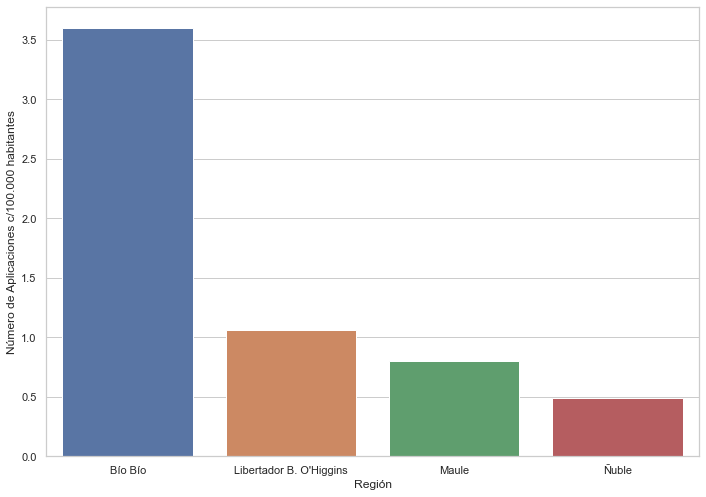

In [64]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style="whitegrid")
ax = sns.barplot(x="ApplicantRegion", y="Per Capita", data=df_agg)
ax.set_ylabel("Número de Aplicaciones c/100.000 habitantes")
ax.set_xlabel("Región")

In [65]:
#Se agrupan las solicitudes por solicitante y año, posteriormente obtenermos los solicitantes que por año realizaron más solicitudes

df_macrozone_top = df_macrozone

df_macrozone_top['Applicants'] = df_macrozone_top["Applicants"].str.upper().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(".", "")

stats2 = df_macrozone_top.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()

df_top = stats2.sort_values('ApplicationNumber', ascending=False).head(20)





C:\Users\Luis\anaconda3\envs\miambiente\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """


In [66]:
#Se realiza un seguimiento histórico a las solicitudes de patentes con las 5 instituciones o emprendedores con más solicitudes

instituciones = ["UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"]

#Array_register_data contiene la data de estas instituciones con más registros, esto se crea con el objetivo de tener el número de aplicaciones por solicitante de la institucion 

array_applicants_data = []

for i in array_registers:
    data = df_macrozone2[df_macrozone2["Applicants"].str.contains(i, regex=True, na=False)]
    data = data.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    array_applicants_data.append(data)
    

array_applicants_data[3]

,Applicants,Year,ApplicationNumber
0,(CL) MARIO GUERRERO MENDEZ,2014,1
1,(CL) MARIO GUERRERO MENDEZ,2017,2


In [67]:
#Segumiento histórico de las patentes registradas de las 5 instituciones o emprendedores con más solicitudes

instituciones = ["UNIVERSIDAD DE CONCEPCION","UNIVERSIDAD DEL BIO BIO","CONTENEDORES SAN FERNANDO SPA", "MARIO GUERRERO MENDEZ", "VICTOR MANUEL ROSALES ITURRA"]
 
array_registers_data = []

for i in instituciones:
    data = df_macrozone[df_macrozone["Applicants"].str.contains(i, regex=True, na=False)]
    data = data.groupby(["Applicants", "Year"]).agg({"ApplicationNumber": "nunique"}).reset_index()
    data = data.sort_values('Year', ascending=True)
    array_registers_data.append(data)
    


array_registers_data[3]


,Applicants,Year,ApplicationNumber
0,(CL) MARIO GUERRERO MENDEZ,2014,6
1,(CL) MARIO GUERRERO MENDEZ,2015,1
2,(CL) MARIO GUERRERO MENDEZ,2016,1
3,(CL) MARIO GUERRERO MENDEZ,2017,2


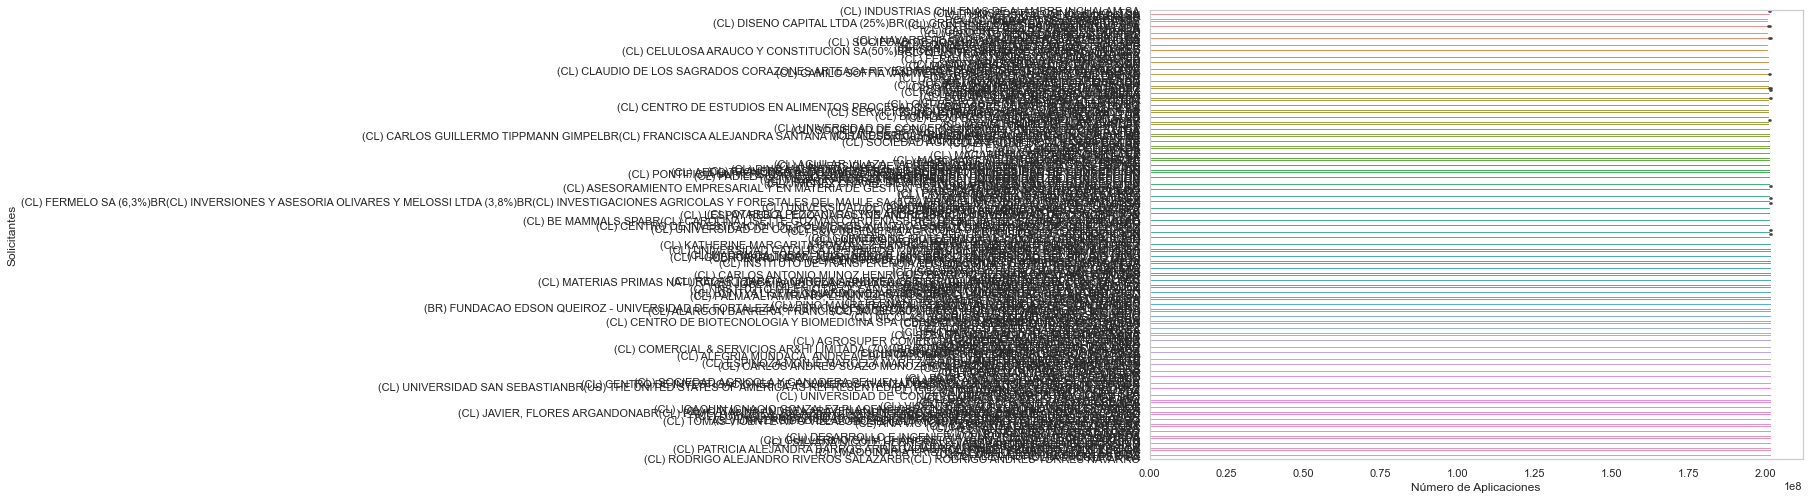

In [68]:
#using function to compare applications vs registers

# Too much data to deploy

grafico(df_macrozone)

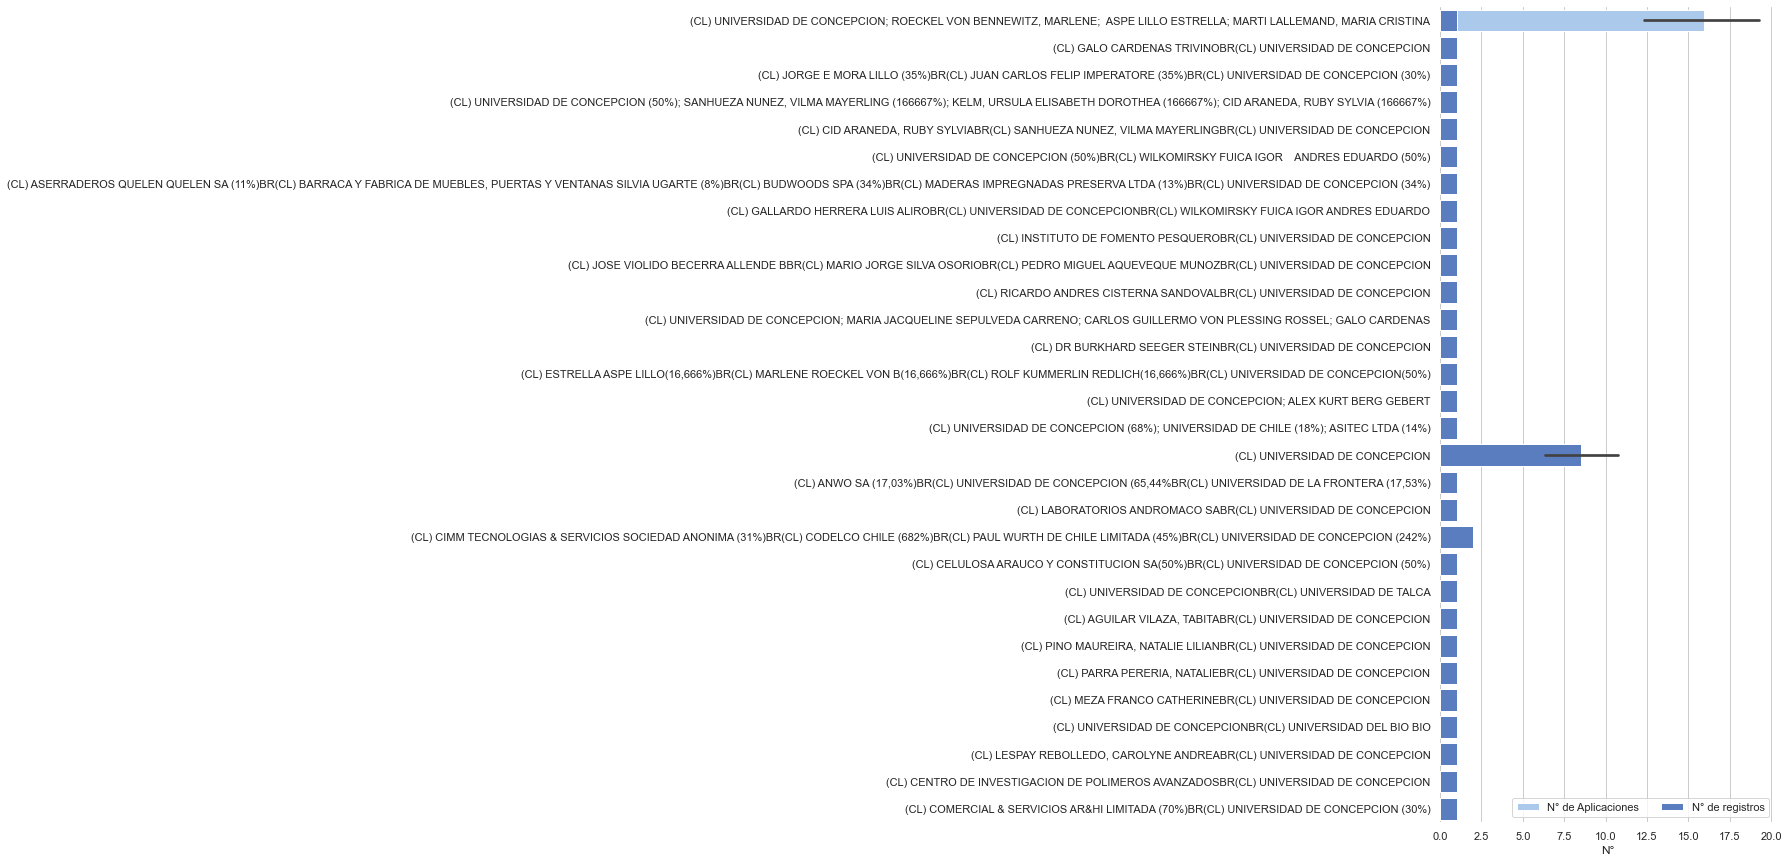

In [69]:
compareGraf(udec,udec_r)

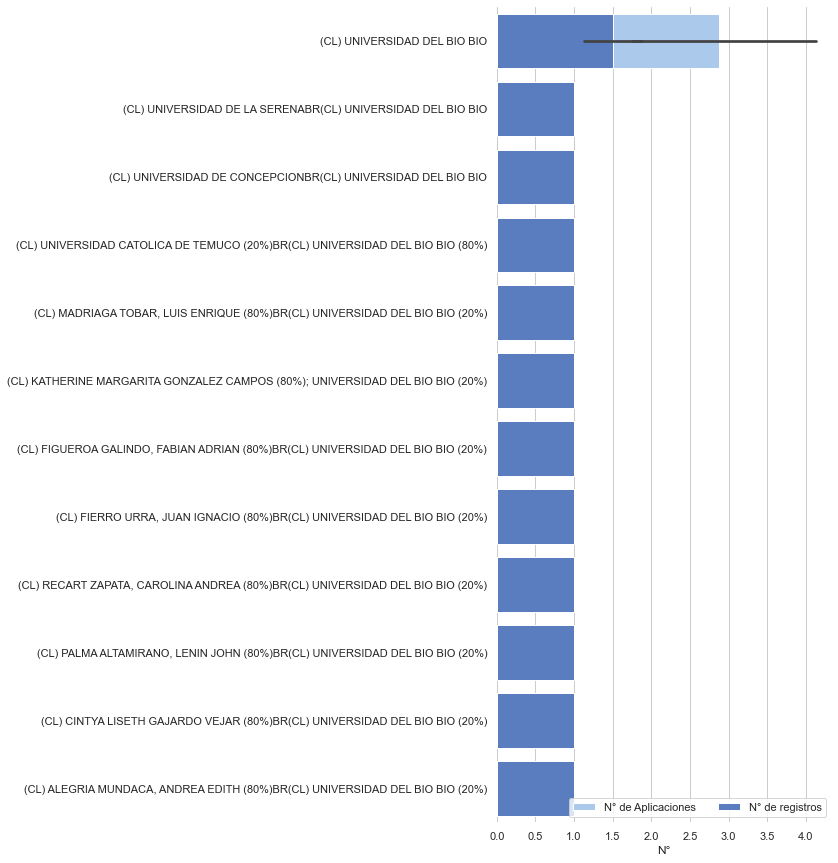

In [70]:
compareGraf(ubb,ubb_r)

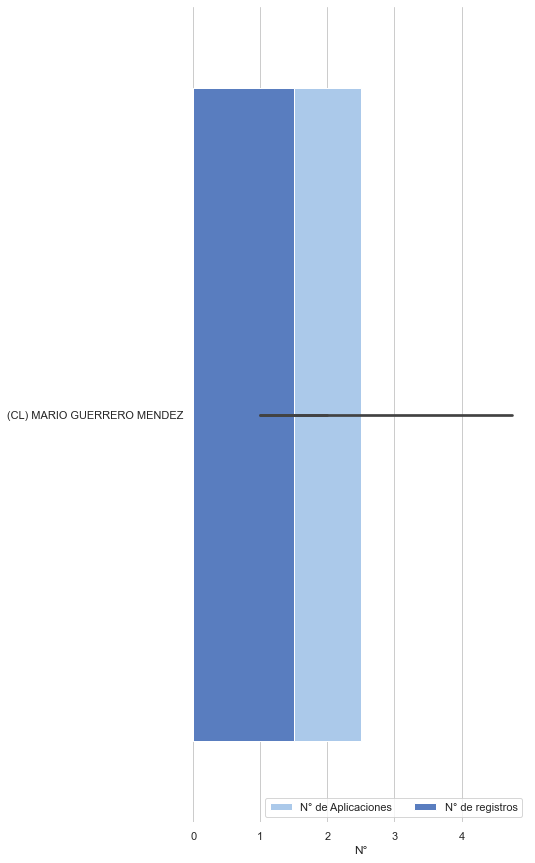

In [71]:
compareGraf(mario_mendez,mario_mendez_r)

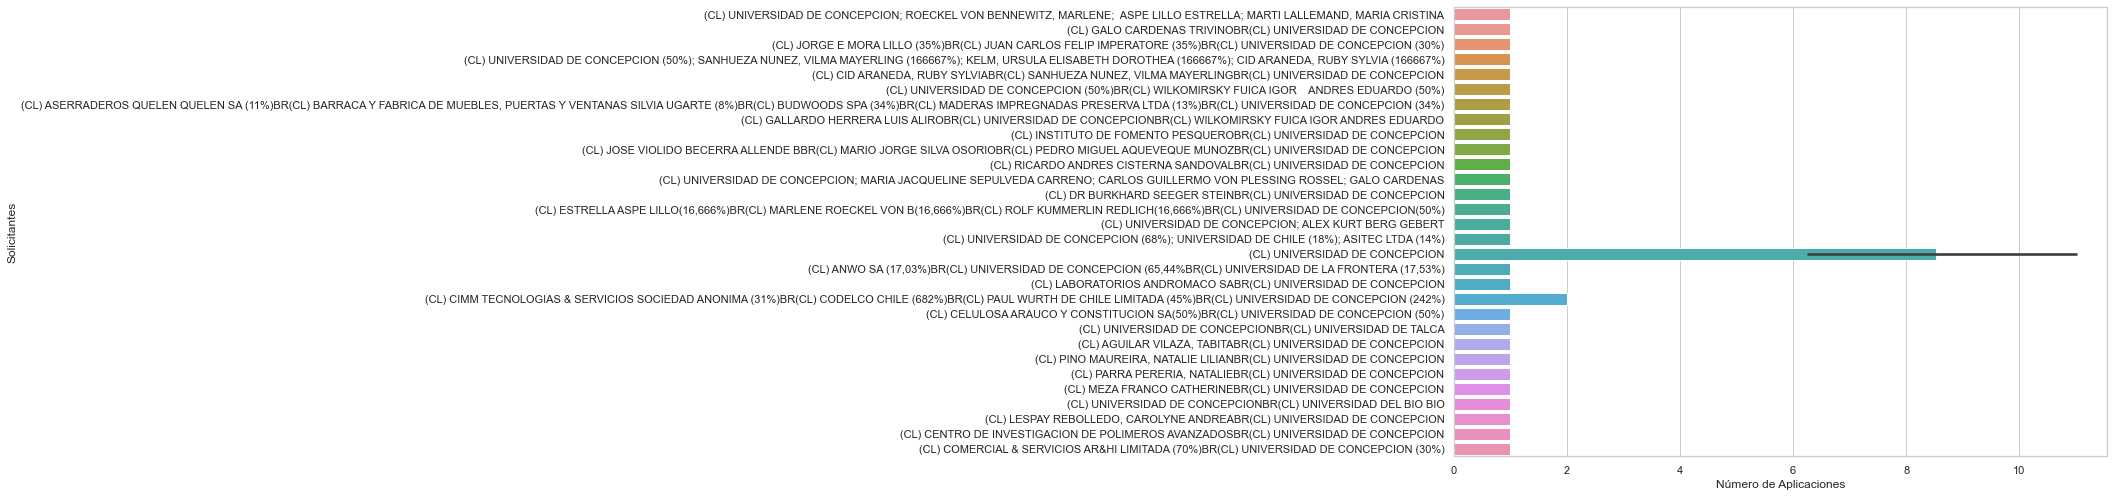

In [72]:
#Gráfico de registros ubb
grafico(udec_r)

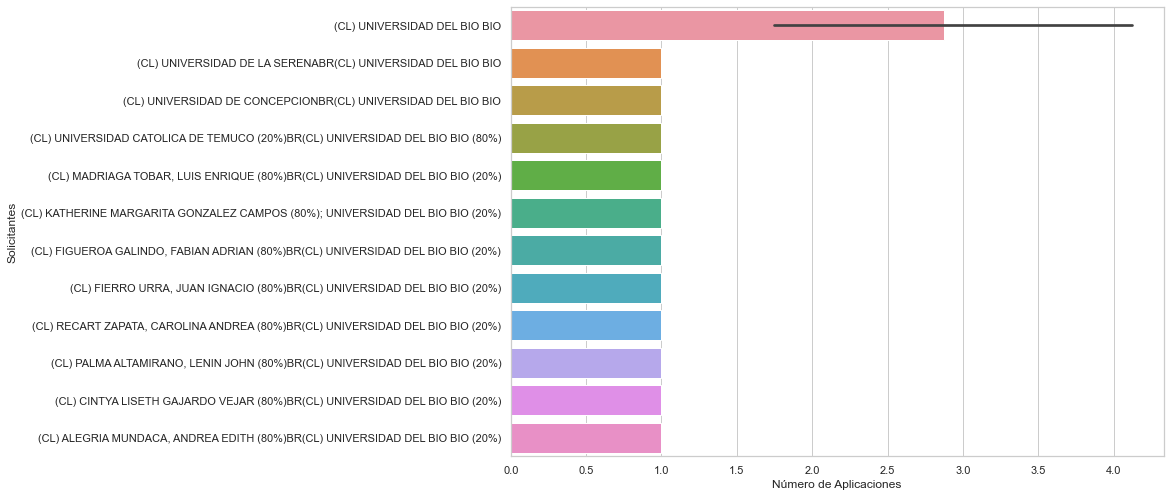

In [73]:
#Gráfico solicitudes ubb
grafico(ubb)

In [74]:
# This cell have a several conflict with previous cells
ubb_r.rename(columns={'ApplicationNumber':'ApplicationNumber_R'},
               inplace=True)

df_agg = df_agg.merge(df_population, on="ApplicantRegion")

ubb = ubb.merge(ubb_r, on =  'Year')

In [75]:
ubb

,Applicants_x,Year,ApplicationNumber,Applicants_y,ApplicationNumber_R
0,(CL) UNIVERSIDAD DEL BIO BIO,2012,1,(CL) UNIVERSIDAD DEL BIO BIO,1
1,(CL) UNIVERSIDAD DEL BIO BIO,2014,1,(CL) UNIVERSIDAD DEL BIO BIO,1
2,(CL) UNIVERSIDAD DEL BIO BIO,2014,1,(CL) UNIVERSIDAD DE LA SERENABR(CL) UNIVERSIDA...,1
3,(CL) UNIVERSIDAD DE LA SERENABR(CL) UNIVERSIDA...,2014,1,(CL) UNIVERSIDAD DEL BIO BIO,1
4,(CL) UNIVERSIDAD DE LA SERENABR(CL) UNIVERSIDA...,2014,1,(CL) UNIVERSIDAD DE LA SERENABR(CL) UNIVERSIDA...,1
...,...,...,...,...,...
67,(CL) CINTYA LISETH GAJARDO VEJAR (80%)BR(CL) U...,2018,1,(CL) CINTYA LISETH GAJARDO VEJAR (80%)BR(CL) U...,1
68,"(CL) ALEGRIA MUNDACA, ANDREA EDITH (80%)BR(CL)...",2019,1,"(CL) ALEGRIA MUNDACA, ANDREA EDITH (80%)BR(CL)...",1
69,"(CL) ALEGRIA MUNDACA, ANDREA EDITH (80%)BR(CL)...",2019,1,(CL) UNIVERSIDAD DEL BIO BIO,1
70,(CL) UNIVERSIDAD DEL BIO BIO,2019,6,"(CL) ALEGRIA MUNDACA, ANDREA EDITH (80%)BR(CL)...",1


In [76]:
print(len(df))
print(len(df['ApplicationNumber'].unique()))

37085
37085


2